In [1]:
%matplotlib widget
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, select, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()


['station', 'measurement']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

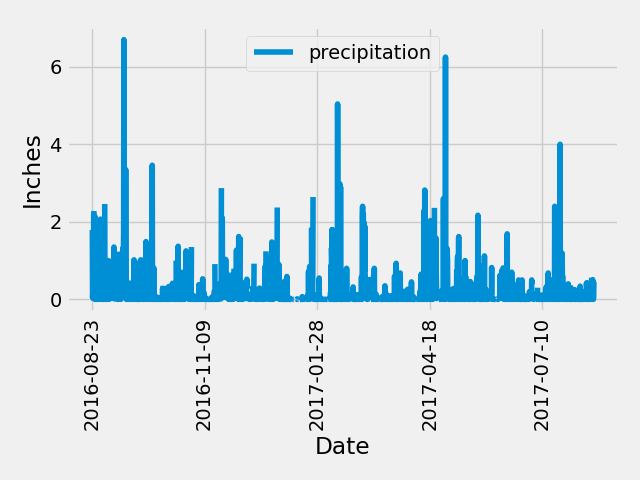

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df = df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df['precipitation'].agg(['count','mean', 'median', 'var', 'std', 'sem'])
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
statement = select(func.count(station.station))

for number_of_stations in session.execute(statement):
    print(f" There are {number_of_stations[0]} stations.")

 There are 9 stations.


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stmt = select(measurement.station, func.count(measurement.station).label("count")).group_by(measurement.station).order_by(desc("count"))

for station, count in session.execute(stmt):
    print(f"{station}\t{count}") 


USC00519281	2772
USC00519397	2724
USC00513117	2709
USC00519523	2669
USC00516128	2612
USC00514830	2202
USC00511918	1979
USC00517948	1372
USC00518838	511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stmt = select(measurement.station, func.count(measurement.station).label("count"))\
            .group_by(measurement.station)\
            .order_by(desc("count")).limit(1)

for stn, count in session.execute(stmt):
    pass #print(f"{stn}\t{count}") 

print(f"Most Active Station: {stn}")
print(f"Lowest Temp\tHighest Temp\tAve Temp")
stmt = select(measurement.station, func.min(measurement.tobs), func.max(measurement.tobs),func.avg(measurement.tobs)).where(measurement.station==stn)
for stn, min_temp, max_temp, avg_temp in session.execute(stmt):
    print(f"{min_temp}\t\t{max_temp}\t\t{avg_temp}")

Most Active Station: USC00519281
Lowest Temp	Highest Temp	Ave Temp
54.0		85.0		71.66378066378067


('2017-08-18',)


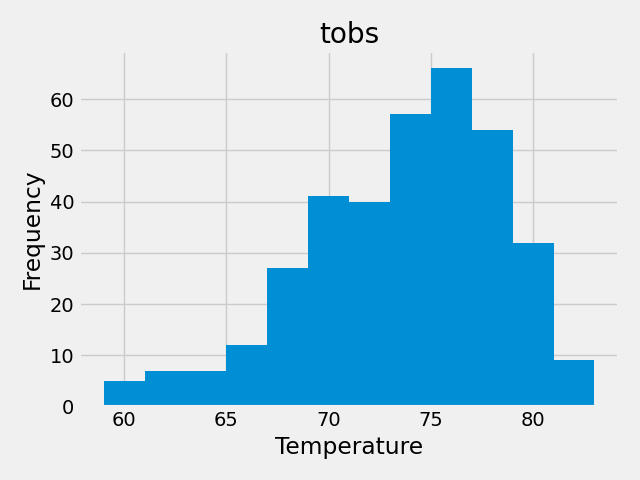

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stmt = select(func.max(measurement.date)).where(measurement.station==stn)
for max_date in session.execute(stmt):
    print(max_date)

stmt = select(measurement.tobs).where(measurement.station==stn, measurement.date>='2016-08-18')
result = session.execute(stmt)
df = pd.DataFrame(result)

plt.close("all")
df.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
# plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()